<a href="https://colab.research.google.com/github/shravan1994/disaster_prediction_using_tweets/blob/main/DisasterTweets_Modelling_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import warnings
warnings.filterwarnings('ignore')

if __name__ == '__main__':
  from google.colab import drive
  drive.mount('/content/drive')

if __name__ == '__main__':
  import os
  os.environ['KAGGLE_CONFIG_DIR'] = "."

  !kaggle competitions download -c nlp-getting-started
  !unzip nlp-getting-started.zip -d 'data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  nlp-getting-started.zip
replace data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [30]:
!pip install contractions
!pip install -q -U "tensorflow-text==2.8.*"
!pip install bert-tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, Conv1D, MaxPool1D, Flatten
from tensorflow.keras import Model
from bert.tokenization import FullTokenizer
from tensorflow.keras.callbacks import Callback
import urllib
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

In [32]:
train_df = pd.read_csv('data/train.csv')
test_df =  pd.read_csv('data/test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [33]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Lets clear the duplicate tweets and manually table the miss-labelled tweets 

In [34]:
train_df = pd.read_csv('data/train.csv')
print('Length of train df before removing duplicates', len(train_df))

duplicated_df = train_df.groupby(['text', 'keyword']).agg(
    target_list=('target', list),
    target_count=('target', len)
).reset_index()

duplicated_df = duplicated_df[duplicated_df['target_count'] > 1].copy()

train_df = train_df[~train_df['text'].isin(duplicated_df['text'])].copy()
print('Length of train df after removing duplicated', len(train_df))

Length of train df before removing duplicates 7613
Length of train df after removing duplicated 7480


**Re-labelling the tweets manually**

In [35]:
duplicated_df[['target_list', 'target_count']] = duplicated_df['target_list'].apply(
    lambda x: pd.Series([x[0] if len(set(x)) == 1 else x, len(set(x))])
    )
parsed_tweets_df = duplicated_df[duplicated_df['target_count'] == 1]
parsed_tweets_df = parsed_tweets_df.rename(columns={'target_list': 'target'}).drop('target_count', axis=1)
parsed_tweets_df.head()

,text,keyword,target
44,#Bestnaijamade: 16yr old PKK suicide bomber wh...,suicide%20bomb,1
113,#KCA #VoteJKT48ID 12News: UPDATE: A family of ...,displaced,1
139,#Myanmar Displaced #Rohingya at #Sittwe point...,displaced,1
155,#Newswatch: 2 vehicles collided at Lock and La...,collided,1
205,#SigAlert: North &amp; Southbound 133 closed b...,fire%20truck,1


In [36]:
relabelled_tweets_df = duplicated_df[duplicated_df['target_count'] > 1]
print(len(relabelled_tweets_df['text'].tolist()))

print(relabelled_tweets_df['text'].tolist())

15
['#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect', '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'Caution: breathing may be hazardous to your health.', 'He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam', 'Hellfire is surrounded by desires so be careful and don\x89Ûªt let your desires control you! #Afterlife', 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!', 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite 

In [37]:
manually_labelled = {
"#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect": 0, 
"#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption": 0,
".POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4": 0,
"CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring": 1,
"Caution: breathing may be hazardous to your health.": 1,
"He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam": 0,
"Hellfire is surrounded by desires so be careful and don\x89Ûªt let your desires control you! #Afterlife": 0,
"Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!": 0,
"In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!": 0,
"RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG": 0,
"The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'": 0,
"To fight bioterrorism sir.": 0, 
"Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE": 0,
"that horrible sinking feeling when you\x89Ûªve been at home on your phone for a while and you realise its been on 3G this whole time": 0,
"wowo--=== 12000 Nigerian refugees repatriated from Cameroon": 0
}

In [38]:
relabelled_tweets_df['target_list'] = relabelled_tweets_df['text'].apply(lambda x: manually_labelled.get(x))
relabelled_tweets_df = relabelled_tweets_df.rename(columns={'target_list': 'target'}).drop('target_count', axis=1)
relabelled_tweets_df.sample(10)

,text,keyword,target
4176,In #islam saving a person is equal in reward t...,terrorism,0
3603,Hellfire! We donÛªt even want to think about ...,hellfire,0
6788,Who is bringing the tornadoes and floods. Who ...,floods,0
5339,RT NotExplained: The only known image of infam...,hijacker,0
2739,Caution: breathing may be hazardous to your he...,hazardous,1
2671,CLEARED:incident with injury:I-495 inner loop...,injury,1
3601,Hellfire is surrounded by desires so be carefu...,hellfire,0
23,#Allah describes piling up #wealth thinking it...,hellfire,0
277,#foodscare #offers2go #NestleIndia slips into ...,hazardous,0
3575,He came to a land which was engulfed in tribal...,engulfed,0


**adding all relaballed tweets back to the training dataframe**

In [39]:
train_df = pd.concat([train_df, parsed_tweets_df, relabelled_tweets_df])
print('length of a new training dataframe', len(train_df))

train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/data/duplicate_removed.csv')

length of a new training dataframe 7526


In [40]:
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/data/duplicate_removed.csv')

## Data Preprocessing

<p>we found a some words in hexadecimal format, they may be some punctuations, so lets print the tweets having such words to analyse first</p>

In [41]:
import re

def replace_byte_chars(tweet):
  tweet = re.sub(r"\x89Ûªs", '\'s', tweet)
  tweet = re.sub(r"\x89Û_", "", tweet)
  tweet = re.sub(r"\x89ÛÒ", "", tweet)
  tweet = re.sub(r"\x89ûó", "", tweet)
  tweet = re.sub(r"\x89ÛÏ", "", tweet)
  tweet = re.sub(r"\x89Û÷", "", tweet)
  tweet = re.sub(r"\x89Û", "", tweet)
  tweet = re.sub(r"\x89Û\x9d", "", tweet)
  tweet = re.sub(r"\x89Û¢", "", tweet)
  tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
  tweet = re.sub(r"åÊ", " ", tweet)
  tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
  tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
  tweet = re.sub(r"Ì©", "e", tweet)
  tweet = re.sub(r"å¨", "", tweet)
  tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
  tweet = re.sub(r"åÇ", "", tweet)
  tweet = re.sub(r"å£3million", "3 million", tweet)
  tweet = re.sub(r"åÀ", "", tweet)
  
  return tweet

In [42]:
import contractions
def do_decontractions(tweet):
  tweet = contractions.fix(tweet)
  return tweet

In [43]:
def clean_tweet(tweet):
  tweet = tweet.lower()
  tweet = replace_byte_chars(tweet)
  tweet = do_decontractions(tweet)
  # removing urls
  tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
  # Words with punctuations and special characters
  tweet = re.sub(r"[\"#$%&'()*+,\-.\/:;<=>@[\]^_`{|}~]", "", tweet)
  # adding space in front of ? and !
  tweet = re.sub(r"([?!]+)", r" \1", tweet)
  tweet = re.sub(r"\s+", " ", tweet)
  tweet = tweet.strip()
  return tweet

In [44]:
processed_train_df = train_df.copy()
processed_train_df['text'] = processed_train_df['text'].apply(lambda x: clean_tweet(x))
test_df['text'] = test_df['text'].apply(lambda x: clean_tweet(x))

processed_train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/data/final_processed.csv')
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/data/final_processed_test_data.csv')
processed_train_df.head()

,id,keyword,location,text,target
0,1.0,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4.0,NaN,NaN,forest fire near la ronge sask canada,1
2,5.0,NaN,NaN,all residents asked to shelter in place are be...,1
3,6.0,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7.0,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [45]:
# processed_train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/data/final_processed.csv')

# Modelling 

## Using Bert

In [46]:
max_seq_length = 128

### Train Test split

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
X_train, X_val, y_train, y_val = train_test_split(
    processed_train_df['text'], processed_train_df['target'], stratify=processed_train_df['target'], test_size=0.2
)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(6020,)
(1506,)
(6020,)
(1506,)


In [49]:
labels_train = y_train.tolist()
labels_train = np.array(labels_train).reshape(-1, 1)

labels_test = y_val.tolist()
labels_test = np.array(labels_test).reshape(-1, 1)

In [50]:
# refered this: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
import tensorflow_hub as hub
import tensorflow_text

In [51]:
# BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
bert_preprocess_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name='bert_preprocessing')
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4', trainable=True, name='bert_layer')

### Defining neural network

In [52]:
# bert model on text data
input_layer1 = Input(shape=(), dtype=tf.string, name='text-layer')
text_preprocessed = bert_preprocess_model(input_layer1)
bert_outputs = bert_layer(text_preprocessed)
pooled_out = bert_outputs['pooled_output']
dropout_1 = Dropout(0.1)(pooled_out)

#############
dense1 = tf.keras.layers.Dense(128,activation='relu')(dropout_1)
dense2 = tf.keras.layers.Dense(128,activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(64,activation='relu')(dense2)
dropout_2 = tf.keras.layers.Dropout(0.2)(dense3)
##########

output = Dense(1, activation='sigmoid')(dropout_2)

model = Model(input_layer1, output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text-layer (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 bert_preprocessing (KerasLayer  {'input_type_ids':   0          ['text-layer[0][0]']             
 )                              (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

### Callback for metrics

In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score

class F1ScoreCallback(Callback):
    def __init__(self, train_data=(), val_data=()):
        super().__init__()
        self.X_train, self.y_train = train_data
        self.train_f1_scores = []
        
        self.X_val, self.y_val = val_data
        self.val_f1_scores = [] 
               
    def on_epoch_end(self, epoch, logs={}):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))        
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_f1_scores.append(train_f1)
        
        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_f1_scores.append(val_f1)

        print('\nEpoch: {} -Training F1: {:.6}'.format(epoch + 1, train_f1))
        print('Epoch: {}  -Validation F1: {:.6}'.format(epoch + 1, val_f1))  

### Compiling and Training Model

In [54]:
EPOCHS = 20
batch_size = 32

In [55]:
from tensorflow.keras.optimizers import SGD, Adam
optimizer = SGD(learning_rate=0.0001, momentum=0.8)
# optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
model_path = '/content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/model/best_bert_model.h5'

metrics = F1ScoreCallback((X_train, labels_train), (X_val, labels_test))
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_path, 
                                       monitor="val_accuracy", save_best_only=True, verbose=10, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.9, patience=3, verbose=10),
    metrics
]

history = model.fit(
    X_train,
    labels_train,
    validation_data=(X_val, labels_test),
    epochs=5, #EPOCHS,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/5
189/189 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.5566
Epoch 1: val_accuracy improved from -inf to 0.66799, saving model to /content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/model/best_bert_model.h5

Epoch: 1 -Training F1: 0.641444
Epoch: 1  -Validation F1: 0.635446
189/189 [==============================] - 191s 926ms/step - loss: 0.6886 - accuracy: 0.5566 - val_loss: 0.6464 - val_accuracy: 0.6680 - lr: 1.0000e-04
Epoch 2/5
189/189 [==============================] - ETA: 0s - loss: 0.6417 - accuracy: 0.6578
Epoch 2: val_accuracy improved from 0.66799 to 0.72643, saving model to /content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/model/best_bert_model.h5

Epoch: 2 -Training F1: 0.717951
Epoch: 2  -Validation F1: 0.714966
189/189 [==============================] - 226s 1s/step - loss: 0.6417 - accuracy: 0.6578 - val_loss: 0.5998 - val_accuracy: 0.7264 - lr: 1.0000e-04
Epoch 3/5
189/18

In [ ]:
history = model.fit(
    X_train,
    labels_train,
    validation_data=(X_val, labels_test),
    epochs=5, #EPOCHS,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/5
189/189 [==============================] - ETA: 0s - loss: 0.4798 - accuracy: 0.7920
Epoch 1: val_accuracy improved from 0.78951 to 0.79681, saving model to /content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/model/best_bert_model.h5

Epoch: 1 -Training F1: 0.799227
Epoch: 1  -Validation F1: 0.792545
189/189 [==============================] - 211s 1s/step - loss: 0.4798 - accuracy: 0.7920 - val_loss: 0.4645 - val_accuracy: 0.7968 - lr: 1.0000e-04
Epoch 2/5
189/189 [==============================] - ETA: 0s - loss: 0.4649 - accuracy: 0.8055
Epoch 2: val_accuracy improved from 0.79681 to 0.81009, saving model to /content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/model/best_bert_model.h5

Epoch: 2 -Training F1: 0.814204
Epoch: 2  -Validation F1: 0.805144
189/189 [==============================] - 183s 972ms/step - loss: 0.4649 - accuracy: 0.8055 - val_loss: 0.4463 - val_accuracy: 0.8101 - lr: 1.0000e-04
Epoch 3/5
189

In [57]:
# model.load_weights(model_path)
# model.save(model_path)

In [58]:
# model = tf.keras.models.load_model(model_path, custom_objects={'KerasLayer':hub.KerasLayer})
# model.fit(
#     X_train,
#     labels_train,
#     validation_data=(X_val, labels_test),
#     epochs=EPOCHS,
#     batch_size=batch_size,
#     callbacks=callbacks
# )

### Training plots

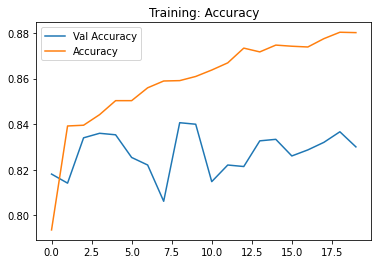

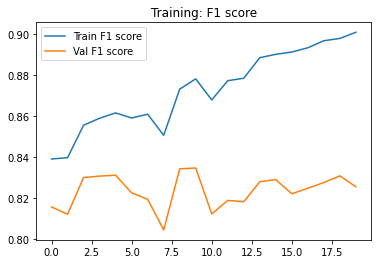

In [ ]:
train_f1_score = metrics.train_f1_scores
val_f1_score = metrics.val_f1_scores

plt.plot(range(EPOCHS), history.history['val_accuracy'], label='Val Accuracy')
plt.plot(range(EPOCHS), history.history['accuracy'], label='Accuracy')
plt.title('Training: Accuracy')
plt.legend()
plt.show()


plt.plot(range(EPOCHS), train_f1_score, label='Train F1 score')
plt.plot(range(EPOCHS), val_f1_score, label='Val F1 score')
plt.title('Training: F1 score')
plt.legend()
plt.show()

### Predict on test data

In [59]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/model/best_bert_model.h5')

predicted_df = test_df.copy()
predicted_target = model.predict(predicted_df['text'])
predicted_df['pred_prob'] = predicted_target

In [60]:
predicted_df['target'] = predicted_df['pred_prob'].apply(lambda x: x > 0.5).astype(int)
predicted_df = predicted_df.drop(['keyword', 'location', 'text', 'pred_prob'], axis=1)
predicted_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [61]:
predicted_df.to_csv('submission_using_bert.csv', index=False)
!kaggle competitions submit -c nlp-getting-started -f submission_using_bert.csv -m "Message"

100% 22.2k/22.2k [00:03<00:00, 7.19kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

## Using Universal sentence encoder

In [ ]:
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

In [ ]:
input_layer2 = Input(shape=(), dtype=tf.string, name='text-layer')
text_preprocessed = use_layer(input_layer2)
dense1 = Dense(128, activation='relu')(text_preprocessed)
dropout1 = Dropout(0.2)(dense1)
output = Dense(1, activation='sigmoid')(dropout1)

model_use = Model(input_layer2, output)
model_use.compile(loss= "binary_crossentropy", optimizer='adam', metrics=["accuracy"])
model_use.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text-layer (InputLayer)     [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_42 (Dense)            (None, 128)               65664     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_use_path = '/content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/model/best_use_model.h5'
metrics1 = F1ScoreCallback((X_train, labels_train), (X_val, labels_test))
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_use_path, 
                                       monitor="val_accuracy", save_best_only=True, verbose=10, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.9, patience=3, verbose=10),
    metrics1
]

history1 = model_use.fit(
    X_train,
    labels_train,
    validation_data=(X_val, labels_test),
    epochs=EPOCHS,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/20
94/95 [============================>.] - ETA: 0s - loss: 0.5418 - accuracy: 0.7663
Epoch 1: val_accuracy improved from -inf to 0.79416, saving model to /content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/model/best_use_model.h5

Epoch: 1 -Training F1: 0.804029
Epoch: 1  -Validation F1: 0.788324
95/95 [==============================] - 14s 136ms/step - loss: 0.5416 - accuracy: 0.7664 - val_loss: 0.4427 - val_accuracy: 0.7942 - lr: 0.0010
Epoch 2/20
94/95 [============================>.] - ETA: 0s - loss: 0.4237 - accuracy: 0.8095
Epoch 2: val_accuracy improved from 0.79416 to 0.81142, saving model to /content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/model/best_use_model.h5

Epoch: 2 -Training F1: 0.81605
Epoch: 2  -Validation F1: 0.806077
95/95 [==============================] - 8s 85ms/step - loss: 0.4238 - accuracy: 0.8095 - val_loss: 0.4220 - val_accuracy: 0.8114 - lr: 0.0010
Epoch 3/20
93/95 [================

In [ ]:
model_use.load_weights(model_use_path)
model_use.save(model_use_path)

### Training plots

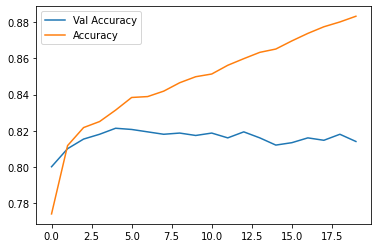

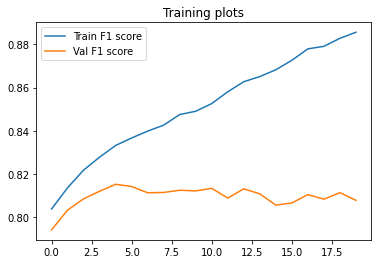

In [ ]:
train_f1_score = metrics1.train_f1_scores
val_f1_score = metrics1.val_f1_scores

plt.plot(range(20), history1.history['val_accuracy'], label='Val Accuracy')
plt.plot(range(20), history1.history['accuracy'], label='Accuracy')
plt.legend()
plt.show()

plt.plot(range(20), train_f1_score, label='Train F1 score')
plt.plot(range(20), val_f1_score, label='Val F1 score')
plt.title('Training plots')
plt.legend()
plt.show()

### Predict on test data

In [ ]:
predicted_df = test_df.copy()
predicted_target = model_use.predict(predicted_df['text'])
predicted_df['pred_prob'] = predicted_target

In [ ]:
predicted_df['target'] = predicted_df['pred_prob'].apply(lambda x: x > 0.5).astype(int)
predicted_df = predicted_df.drop(['keyword', 'location', 'text', 'pred_prob'], axis=1)
predicted_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
predicted_df.to_csv('submission_use.csv', index=False)

In [ ]:
model

## Using CNN with Bi-directional LSTM

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-08-15 08:29:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-15 08:29:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-15 08:29:43--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
t = tf.keras.preprocessing.text.Tokenizer()
t.fit_on_texts(X_train)
vocab_size = len(t.word_index) + 1

In [ ]:
path_to_glove_file = os.path.join("/content/glove.6B.100d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
num_tokens = vocab_size + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

In [ ]:
input_layer = Input(shape=(140,), name='text-layer')

embedd = embedding_layer(input_layer)

lstm = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(128, kernel_regularizer=tf.keras.regularizers.L2(0.001), return_sequences=True)
)(embedd)

conv1 = Conv1D(128, 3, padding='same', activation='relu')(lstm)
max_pool = tf.keras.layers.MaxPooling1D()(conv1)
flat = Flatten()(max_pool)
dropout_2 = tf.keras.layers.Dropout(0.4)(flat)
dense1 = Dense(256, activation='relu')(dropout_2)
output = Dense(1, activation='sigmoid')(dense1)

model_cnn = Model(inputs=input_layer, outputs=output)

In [ ]:

from tensorflow.keras.optimizers import SGD, Adam
# optimizer = SGD(learning_rate=0.0001, momentum=0.8)
optimizer = Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_cnn.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text-layer (InputLayer)     [(None, 140)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 140, 100)          1564700   
                                                                 
 bidirectional_6 (Bidirectio  (None, 140, 256)         234496    
 nal)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 140, 128)          98432     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 70, 128)          0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 8960)              0   

In [ ]:
from tensorflow.keras.preprocessing import sequence

X_train_tokens = t.texts_to_sequences(X_train)
X_test_tokens = t.texts_to_sequences(X_val)

max_words = 140
X_train_padded = sequence.pad_sequences(X_train_tokens, maxlen=max_words)
X_test_padded = sequence.pad_sequences(X_test_tokens, maxlen=max_words)

In [ ]:
model_cnn_path = '/content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/model/best_cnn_model.h5'

EPOCHS = 10
metrics3 = F1ScoreCallback((X_train_padded, labels_train), (X_test_padded, labels_test))
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_cnn_path, 
                                       monitor="val_accuracy", save_best_only=True, verbose=10, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.9, patience=3, verbose=10),
    metrics3
]

history3 = model_cnn.fit(
    X_train_padded,
    labels_train,
    validation_data=(X_test_padded, labels_test),
    epochs=EPOCHS,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/10
95/95 [==============================] - ETA: 0s - loss: 0.8307 - accuracy: 0.7269
Epoch 1: val_accuracy improved from -inf to 0.77092, saving model to /content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/model/best_cnn_model.h5

Epoch: 1 -Training F1: 0.859068
Epoch: 1  -Validation F1: 0.749001
95/95 [==============================] - 12s 98ms/step - loss: 0.8307 - accuracy: 0.7269 - val_loss: 0.8532 - val_accuracy: 0.7709 - lr: 1.0000e-04
Epoch 2/10
94/95 [============================>.] - ETA: 0s - loss: 0.4608 - accuracy: 0.9257
Epoch 2: val_accuracy did not improve from 0.77092

Epoch: 2 -Training F1: 0.947875
Epoch: 2  -Validation F1: 0.718339
95/95 [==============================] - 4s 45ms/step - loss: 0.4608 - accuracy: 0.9256 - val_loss: 1.0462 - val_accuracy: 0.7198 - lr: 1.0000e-04
Epoch 3/10
95/95 [==============================] - ETA: 0s - loss: 0.3470 - accuracy: 0.9650
Epoch 3: val_accuracy did not improve from 0.77092

Epoch: 3

In [ ]:
model_cnn.load_weights(model_cnn_path)
model_cnn.save(model_cnn_path)

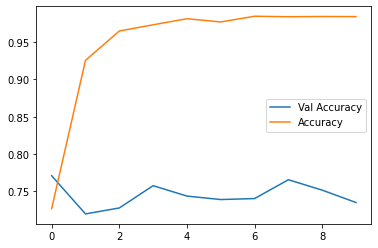

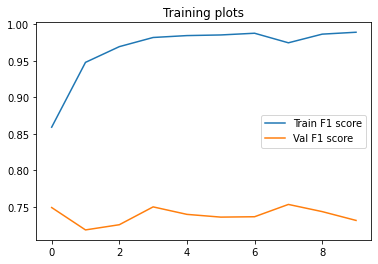

In [ ]:
train_f1_score = metrics3.train_f1_scores
val_f1_score = metrics3.val_f1_scores

plt.plot(range(10), history3.history['val_accuracy'], label='Val Accuracy')
plt.plot(range(10), history3.history['accuracy'], label='Accuracy')
plt.legend()
plt.show()

plt.plot(range(10), train_f1_score, label='Train F1 score')
plt.plot(range(10), val_f1_score, label='Val F1 score')
plt.title('Training plots')
plt.legend()
plt.show()

## Using Bert plus CNN with Bi-directional LSTM

In [19]:
input_layer1 = Input(shape=(), dtype=tf.string, name='text-layer')
text_preprocessed = bert_preprocess_model(input_layer1)
bert_outputs = bert_layer(text_preprocessed)
pooled_out = bert_outputs['pooled_output']
dropout_1 = Dropout(0.1)(pooled_out)
bert_out = tf.keras.layers.Reshape((32,24))(dropout_1)
    
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True), name='bidirectional_lstm')(bert_out)
dropout_3 = tf.keras.layers.Dropout(0.1)(lstm)
cnn = tf.keras.layers.Conv1D(64,5, name='convolution-layer')(dropout_3)

max_pool = tf.keras.layers.MaxPooling1D(25)(cnn)
flat = tf.keras.layers.Flatten(data_format='channels_last')(max_pool)

dense1 = tf.keras.layers.Dense(128,activation='relu')(pooled_out)
dense2 = tf.keras.layers.Dense(64,activation='relu')(dense1)
dropout_2 = tf.keras.layers.Dropout(0.1)(dense2)

concat = tf.keras.layers.Concatenate()([dropout_2,flat])

output = Dense(1,activation='sigmoid')(concat)

model_bert_cnn = Model(inputs=input_layer1, outputs=output)

In [20]:
from tensorflow.keras.optimizers import SGD, Adam
optimizer = SGD(learning_rate=0.0001, momentum=0.8)
model_bert_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model_bert_cnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text-layer (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 bert_preprocessing (KerasLayer  {'input_type_ids':   0          ['text-layer[0][0]']             
 )                              (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

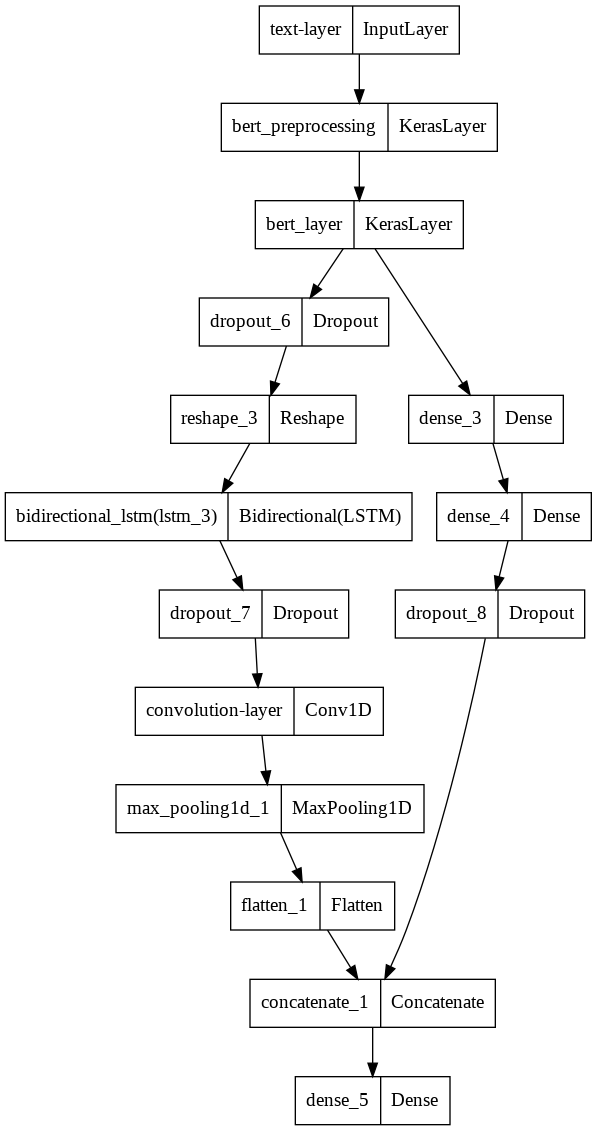

In [21]:
tf.keras.utils.plot_model(
    model_bert_cnn,
    to_file='model_bert_with_cnn.png'
)

In [ ]:
model_bert_cnn_path = '/content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/model/best_bert_cnn_model.h5'

EPOCHS = 20
metrics2 = F1ScoreCallback((X_train, labels_train), (X_val, labels_test))
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_bert_cnn_path,
                                       monitor="val_accuracy", save_best_only=True, verbose=10, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.9, patience=3, verbose=10),
    metrics2
]

history2 = model_bert_cnn.fit(
    X_train,
    labels_train,
    validation_data=(X_val, labels_test),
    epochs=EPOCHS,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/20
95/95 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.8475
Epoch 1: val_accuracy improved from -inf to 0.80677, saving model to /content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/model/best_bert_cnn_model.h5

Epoch: 1 -Training F1: 0.858122
Epoch: 1  -Validation F1: 0.799279
95/95 [==============================] - 215s 2s/step - loss: 0.3805 - accuracy: 0.8475 - val_loss: 0.4408 - val_accuracy: 0.8068 - lr: 1.0000e-04
Epoch 2/20
95/95 [==============================] - ETA: 0s - loss: 0.3719 - accuracy: 0.8542
Epoch 2: val_accuracy improved from 0.80677 to 0.81208, saving model to /content/drive/MyDrive/Colab Notebooks/Self case study/Natutal Disaster prediction/model/best_bert_cnn_model.h5

Epoch: 2 -Training F1: 0.854834
Epoch: 2  -Validation F1: 0.806716
95/95 [==============================] - 175s 2s/step - loss: 0.3719 - accuracy: 0.8542 - val_loss: 0.4465 - val_accuracy: 0.8121 - lr: 1.0000e-04
Epoch 3/20
95/95 

In [ ]:
# model_bert_cnn.load_weights(model_bert_cnn_path)
# model_bert_cnn.save(model_bert_cnn_path)

### Training Plots

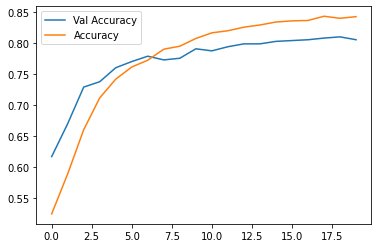

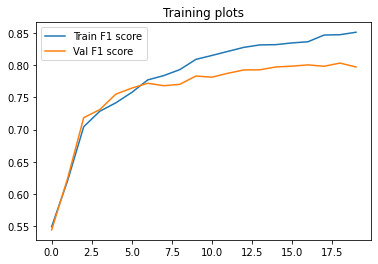

In [ ]:
train_f1_score = metrics2.train_f1_scores
val_f1_score = metrics2.val_f1_scores

plt.plot(range(20), history2.history['val_accuracy'], label='Val Accuracy')
plt.plot(range(20), history2.history['accuracy'], label='Accuracy')
plt.legend()
plt.show()

plt.plot(range(20), train_f1_score, label='Train F1 score')
plt.plot(range(20), val_f1_score, label='Val F1 score')
plt.title('Training plots')
plt.legend()
plt.show()

### Predict on test data

In [ ]:
predicted_df = test_df.copy()
predicted_target = model3.predict(predicted_df['text'])
predicted_df['pred_prob'] = predicted_target

In [ ]:
predicted_df['target'] = predicted_df['pred_prob'].apply(lambda x: x > 0.5).astype(int)
predicted_df = predicted_df.drop(['keyword', 'location', 'text', 'pred_prob'], axis=1)
predicted_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
predicted_df.to_csv('submission_bert_cnn.csv', index=False)

# Obeservations

<h3>We tried with 2 different models, model names and their corresponding F1 score are listed below</h3>




In [ ]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Model Name", "Train F1 score", "Validation F1 score", "Train Accuracy", "Validation Accuracy"])
  
# Add rows
myTable.add_row(["DNN with BERT", "0.87501", "0.823729", "0.8646", "0.83068"])
myTable.add_row(["DNN with USE", "0.875776", "0.812933", "0.8773", "0.82271"])

myTable.add_row(["DNN with CNN Plus Bidirectional LSTM", "0.97468", "0.753248", "0.9841", "0.7656"])
myTable.add_row(["DNN with Bert encoding and CNN Plus Bidirectional LSTM", "0.843278", "0.823108", "0.8279", "0.82802"])
  
print(myTable)

+--------------------------------------------------------+----------------+---------------------+----------------+---------------------+
|                       Model Name                       | Train F1 score | Validation F1 score | Train Accuracy | Validation Accuracy |
+--------------------------------------------------------+----------------+---------------------+----------------+---------------------+
|                     DNN with BERT                      |    0.87501     |       0.823729      |     0.8646     |       0.83068       |
|                      DNN with USE                      |    0.875776    |       0.812933      |     0.8773     |       0.82271       |
|          DNN with CNN Plus Bidirectional LSTM          |    0.97468     |       0.753248      |     0.9841     |        0.7656       |
| DNN with Bert encoding and CNN Plus Bidirectional LSTM |    0.843278    |       0.823108      |     0.8279     |       0.82802       |
+----------------------------------------